# **CS-473 (Pattern Recognition)**

## Assignment 1 - Bayesian Classifier

##### Nikolaos Kougioulis (csdp1285)

---

In this assignment the task is to familiarize with Bayesian Decision Theory. Assignment’s 1 task is the implementation of a Bayesian classifier and its evaluation on the given Wine dataset. Please use the *’parameters.txt’* file for any variables/information that you might need.

In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#import random 
#import scipy.stats

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("data.csv", sep=",") #wines dataset

Saving data.csv to data.csv


### **Question A:** The model

1. Implement a function that computes the prior probabilities for each class.
2. Compute the posterior probabilities for each sample.
   1. Implement a function that takes as input one sample (one point in the 2-dimensional space), a mean and a covariance matrix and returns the likelihood of that point belonging to the class whose distribution is described by the given mean and covariance matrix.
   2. Implement a function that computes the posterior probabilities for each sample.
3. Save and print the predicted class for each sample, according to the posterior probabilities. What’s the accuracy of your classifier?

---

#### **Solution**

We use the given and pre-computed means vector and variance-covariance matrix, although even if not given, computation is straightforward using Maximum Likelihood estimators.


In [ ]:
number_of_classes = df["labels"].unique() #3

#means for each class for alcohol, color_intensity (given & pre-computed)
means = np.array([
    [13.744746, 5.528305], 
    [12.278732, 3.086620], 
    [13.15375, 7.39625]
])

#variance-covariance matrix for each class for alcohol, color_intensity (given & pre-computed)
covs = np.array([
    [
        [0.213560, 0.233696], 
        [0.233696, 1.534063]
    ],
    [
        [0.289406, 0.134241], 
        [0.134241, 0.855494]
    ],
    [
        [0.281156, 0.429338], 
        [0.429338, 5.340454]
    ]
])

As a helper function (instead of using scipy) the *multivariate_normal* function computes the multivariate normal pdf of an n-dimensional random vector $\displaystyle X \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)$ with $$\begin{split}
f(\boldsymbol{x};\boldsymbol{\mu}, \Sigma_k) = \frac{1}{(2\pi)^{(n/2)} |\Sigma|^{1/2}} \exp \left\{- \frac{1}{2} \left(\boldsymbol{x}-\boldsymbol{\mu} \right)^{'} \Sigma^{-1} \left(\boldsymbol{x}-\boldsymbol{\mu} \right)  \right\}
\end{split}$$

In [ ]:
def multivariate_normal(x, mean, cov):
    n = len(x)
    inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
       
    val = 1/ (math.pow((2*math.pi), float(n)/2) * math.pow(det, 1/2)) * math.exp(-0.5 * (x-mean).T.dot(inv).dot((x-mean)))
    return val

For the classses $\omega_j, ~j=1,2,3$, the class priors are computing from the sample using Maximum LIkelihood Estimation which results in $\displaystyle p(\omega_j) = \frac{N(\omega_j)}{N}$, where $N(\omega_j)$ is the frequency of the $\omega_j$ class in our sample, divided by the total number of samples.


In [ ]:
def class_priors(df):
    #returns the prior aprobabilities for each class, P(\omega_j)

    total_samples = df.shape[0]
    class_counts = df["labels"].value_counts()

    priors = np.array([i/total_samples for i in class_counts])

    return priors

print(class_priors(df))

[0.33333333 0.33333333 0.33333333]


Regarding the likelihood $p(\boldsymbol{x} | \omega_j), ~j=1,2,3$, computation is straightforward using the *find_likelihood* function, given the mean vector and variance-covariance matrix of each class, assuming they are normally distributed:

In [ ]:
def find_likelihood(x, mean, cov):
    #returns the likelihood a sample of features x belongs to the given class with multivariate normal distribution given a mean vector and 
    #a covariance matrix

    det = np.linalg.det(cov)
    inverse = np.linalg.inv(cov)
    mean = np.array(mean)
    
    #return scipy.stats.multivariate_normal.pdf(x, mean, cov)
    return multivariate_normal(x, mean, cov)

#example: likelihood for two random feature vectors, the first around the region of the first class, and the second around the third class
print("Likelihood of feature vector (11,13.58) to belong to class 1: ", find_likelihood([12.32,3.41], means[0], covs[0]), "\n")
print("Likelihood of feature vector (15,11) to belong to class 1: ", find_likelihood([16.91,11.67], means[0], covs[0]))

Likelihood of feature vector (11,13.58) to belong to class 1:  0.00232604069278424 

Likelihood of feature vector (15,11) to belong to class 1:  1.1977910764918446e-12


By definition, likelihood is quite misleading. Note that these likelihoods are very close to zero. If we want to be mathematically strict, for continuous variables one computes probabilities at intervals and not at a point, so such numerical values have no value on their own. In a more general sense, without going into details, our above evaluation around a point $p \in \mathbb{R}^2$ is the probability to find the point around a small enough interval.

Given a class $\omega_j$ and a feature vector $\boldsymbol{x}$, we can now compute the posterior probabilities using Bayes' formula $\displaystyle p(\omega_j | \boldsymbol{x}) = \frac{p(\omega_j,x)}{p(\boldsymbol{x})} = \frac{p(\boldsymbol{x}|\omega_j)p(\omega_j)}{p(\boldsymbol{x})}$, where the predicted prior probability $p(\boldsymbol{x})$ is $\displaystyle p(\boldsymbol{x}) = \sum_{j=1}^{3} p(\boldsymbol{x}|\omega_j)p(\omega_j)$.

In [ ]:
def find_posterior(df, means, covs): 
    #returns the posterior probability for each class for each sample
    #given the mean vectors and variance-covariance matrices of the classes

    priors = np.array([1/3, 1/3, 1/3])
    
    #likelihood array for every class
    likelihoods = np.array([find_likelihood([df["alcohol"][k], df["color_intensity"][k]], means[l], covs[l])
                             for k in range(df.shape[0]) for l in range(3)]).reshape(df.shape[0], 3)
                             
    #sum of the three conditional probabilities of each sample given the class
    predicted_prior = np.sum(likelihoods)*priors

    return likelihoods * priors / (predicted_prior) #rows are samples, columns are classes

posteriors = find_posterior(df, means, covs)

print("Posteriors: \n", posteriors[:10])

Posteriors: 
 [[7.12299920e-04 2.87524596e-11 1.26963808e-03]
 [9.20833366e-03 9.00644668e-07 3.30683009e-04]
 [1.02110673e-02 5.19335957e-06 3.20835224e-04]
 [6.19178216e-03 6.00165611e-04 6.04744215e-04]
 [4.90241028e-03 3.86964575e-06 1.00450167e-04]
 [5.95692730e-03 1.48827429e-03 5.06310914e-03]
 [3.51142491e-04 1.92213254e-11 2.85047031e-03]
 [1.36110972e-02 2.76880145e-05 4.40739495e-03]
 [1.06861221e-02 1.83048464e-03 3.23741175e-03]
 [3.53038257e-03 7.32195487e-03 2.03306403e-03]]


To predict the class of each sample, using the vector of feautures $\boldsymbol{x}$ according to the posterior probabilities, we simply select the class with the highest posterior, that is, for a sample $s$ with feauture vector $\boldsymbol{x}:$

$$\omega_{\boldsymbol{x}} = \text{argmax}_{i} \left\{p(\omega_i | \boldsymbol{x}), ~i=1,2,3 \right\}$$

In [ ]:
predicted_classes = np.argmax(find_posterior(df, means, covs), axis=1)

print("Predicted Classes: \n", predicted_classes)

accuracy = np.sum(predicted_classes == df["labels"])/df.shape[0]
print("Accuracy: ", accuracy)

Predicted Classes: 
 [2 0 0 0 0 0 2 0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2
 2 0 2 2 0 2 2 2 0 2 2 2 1 2 0 2]
Accuracy:  0.8444444444444444


### **Question B:** Conditional Risk
1. Compute the conditional risk for every sample.
2. Save and print the predicted class for each sample, in order to minimize the conditional risk. What’s the accuracy now? What do you notice and why do you think this is the case?

#### **Solution**

In [ ]:
#negation of Kronecher's delta, \delta(x,y) = 1 for x=y, 0 elsewhere 
'''
def neg_kronechers_delta(x,y):
    if x ==y :
        return 0 
    else:
        return 1
'''
#price of each wine class
price_0, price_1, price_2 = 10, 12, 14

#loss matrix for each action and true class
loss_matrix = np.array([
    [0, price_1/price_0, price_2/price_0],
    [price_0/price_1, 0, price_2/price_1],
    [price_0/price_2, price_1/price_2, 0]
    ])

Suppose we observe $\mathbf{x}$ and take action $a_i$. If the true state of nature is $w_j$, we incur the loss $\lambda (a_i | w_j)$. The expected loss with taking action $a_i$ is 

$$\displaystyle R(a_i|\mathbf{x}) = \sum_{j=1}^{n} \lambda(a_i|\omega_j)P(\omega_j | \mathbf{x})$$

where $\lambda$ is the loss function.

We define our loss function as the relative profit loss, using the respective selling prices of the three wine classes. More precisely, $\lambda(\alpha_i | \omega_j) = \frac{\text{price}_i}{\text{price}_j}, ~\forall i\neq j, ~\lambda(\alpha_i, \omega_j) = 0$ otherwise. This results in the loss matrix 

 $$\begin{pmatrix} 0 & 12/10 & 14/10\\ 10/12 & 0 & 14/12 \\ 10/14 & 12/14 & 0 \end{pmatrix}$$ 

In [ ]:
def conditional_risk(df, means, covs):
    #returns the conditional risks for each class given the sample

    number_of_classes = df["labels"].unique()

    #one-two loss function defined using Kronecher's delta
    #loss = np.array([comp_kronechers_delta(i, j) for i in range(3) for j in range(3)]).reshape(3, 3)
    loss = np.array([loss_matrix[i][j] for i in range(3) for j in range(3)]).reshape(3, 3)

    print("loss matrix: ", loss)

    #compute the posterior probability for each class for each sample
    posterior = find_posterior(df, means, covs)
    
    print("Posterior probabilities: \n", posterior[:10])

    #FIXME: Conditional risk using loss_matrix instead of zero-one loss function
    #conditional_risk = np.array([np.sum(posterior[i]*loss[kronechers_delta(df["labels"][i], j)]) for i in range(df.shape[0]) for j in range(3)]).reshape(df.shape[0], 3)
    #DONE
    conditional_risk = np.array([np.sum(posterior[i]*loss[:,j]) for i in range(df.shape[0]) for j in range(3)]).reshape(df.shape[0], 3)

    return conditional_risk

print("Conditional risks for each class: \n", conditional_risk(df, means, covs)[:10])

loss matrix:  [[0.         1.2        1.4       ]
 [0.83333333 0.         1.16666667]
 [0.71428571 0.85714286 0.        ]]
Posterior probabilities: 
 [[7.12299920e-04 2.87524596e-11 1.26963808e-03]
 [9.20833366e-03 9.00644668e-07 3.30683009e-04]
 [1.02110673e-02 5.19335957e-06 3.20835224e-04]
 [6.19178216e-03 6.00165611e-04 6.04744215e-04]
 [4.90241028e-03 3.86964575e-06 1.00450167e-04]
 [5.95692730e-03 1.48827429e-03 5.06310914e-03]
 [3.51142491e-04 1.92213254e-11 2.85047031e-03]
 [1.36110972e-02 2.76880145e-05 4.40739495e-03]
 [1.06861221e-02 1.83048464e-03 3.23741175e-03]
 [3.53038257e-03 7.32195487e-03 2.03306403e-03]]
Conditional risks for each class: 
 [[9.06884368e-04 1.94302112e-03 9.97219921e-04]
 [2.36952687e-04 1.13334430e-02 1.28927179e-02]
 [2.33495817e-04 1.25282824e-02 1.43015532e-02]
 [9.32098162e-04 7.94849077e-03 9.36868823e-03]
 [7.49748244e-05 5.96899248e-03 6.86788898e-03]
 [4.85673510e-03 1.14881206e-02 1.00760182e-02]
 [2.03605024e-03 2.86463126e-03 4.91599510e-0

To predict the optimal class using the conditional risk defined above, one simply selects the action (class) with the minimum conditional risk, that is, for an observed feature $\boldsymbol{x}$:

 $$\displaystyle \omega_{\boldsymbol{x}} = \text{argmin}_i  \left\{ R(a_i|\mathbf{x}) / ~i=1,2,3 \right\} = \left\{ \sum_{j=1}^{n} \lambda(a_i|\omega_j)P(\omega_j | \mathbf{x}) ~/ i=1,2,3 \right\}$$

In [ ]:
#select the class with the minimum conditional risk for each sample
risk_predicted_classes = np.argmin(conditional_risk(df, means, covs), axis=1)

print("Predicted classes using the conditional risk: \n", risk_predicted_classes)

risk_accuracy = np.sum(risk_predicted_classes == df["labels"])/df.shape[0]
print("Accuracy using the conditional risk: ", risk_accuracy)


loss matrix:  [[0.         1.2        1.4       ]
 [0.83333333 0.         1.16666667]
 [0.71428571 0.85714286 0.        ]]
Posterior probabilities: 
 [[7.12299920e-04 2.87524596e-11 1.26963808e-03]
 [9.20833366e-03 9.00644668e-07 3.30683009e-04]
 [1.02110673e-02 5.19335957e-06 3.20835224e-04]
 [6.19178216e-03 6.00165611e-04 6.04744215e-04]
 [4.90241028e-03 3.86964575e-06 1.00450167e-04]
 [5.95692730e-03 1.48827429e-03 5.06310914e-03]
 [3.51142491e-04 1.92213254e-11 2.85047031e-03]
 [1.36110972e-02 2.76880145e-05 4.40739495e-03]
 [1.06861221e-02 1.83048464e-03 3.23741175e-03]
 [3.53038257e-03 7.32195487e-03 2.03306403e-03]]
Predicted classes using the conditional risk: 
 [0 0 0 0 0 0 2 0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 0 0 2 2 2 0 2 2 2 2
 2 0 2 2 0 2 2 2 0 2 2 2 1 2 0 0]
Accuracy using the conditional risk:  0.8333333333333334


Note that the accuracy using the conditional risk is a bit lower than the one we used before by taking the maximum class of each posterior. This is directly dependent on the choice of the loss function and is highly subjective based on the expect's knowledge. Here the loss function is selected by relation to our profit, since what we are looking for is to maximize our own profit and not the emotional "profit" of our customers by offering them a more expensive wine at a lower price.

For example if we have chosen the *zero-one loss function* $\lambda(\alpha_i | \omega_j) = 0$ for $i=j$ and $\lambda(\alpha_i | \omega_j) = 1$ otherwise, we would have obtained a different score due to our subjective change of loss.

### **Question C**: Plot Results

1. Create a scatter plot that also shows the distribution of each class and the decision boundaries of your
classifier.

#### **Solution**

The theoretical implementation would be to consider the general multivariate case (Chapter 2.6.3) and algebrically obtain the decision surfaces (and then the boundaries) by solving 

$$g_0(x) = g_1(x), ~g_0(x) = g_2(x), ~g_1(x) = g_2(x)$$

(a total of $\binom{3}{2} = 3$ decision surfaces)

with the inherently quadratic discriminant functions

$g_i (\boldsymbol{x}) = \boldsymbol{x}^{'} \boldsymbol{W}_i \boldsymbol{x} + \boldsymbol{w}^{'}_{i} \boldsymbol{x} + \boldsymbol{w}_{i0}$

where $\boldsymbol{W}_i = -\frac{1}{2} \boldsymbol{\Sigma}^{-1}$, $\boldsymbol{w}_i = \boldsymbol{\Sigma}^{-1}_{i} \boldsymbol{\mu}_i $  and $w_{i0} = -\frac{1}{2} \boldsymbol{\mu}^{'}_{i} \boldsymbol{\Sigma}^{-1}_{i} - \frac{1}{2} \ln | \boldsymbol{\Sigma}_i | + \ln p(\omega_i)$.

For computational purposes, we create a meshgrid by 50 generated feature samples and then plot the decision boundaries based on the predicted class of each generated sample.

<bound method NDFrame.head of         alcohol  color_intensity
0     11.000000              2.0
1     11.091837              2.0
2     11.183673              2.0
3     11.275510              2.0
4     11.367347              2.0
...         ...              ...
2495  15.132653             12.0
2496  15.224490             12.0
2497  15.316327             12.0
2498  15.408163             12.0
2499  15.500000             12.0

[2500 rows x 2 columns]>
[[3.91271851e-11 1.10536586e-04 1.47656527e-07]
 [1.19364752e-10 1.59000638e-04 2.75395416e-07]
 [3.47289108e-10 2.21636756e-04 4.96374923e-07]
 ...
 [8.96024393e-10 9.93766738e-26 1.85000497e-07]
 [6.46788942e-10 5.58290498e-26 9.33013038e-08]
 [4.45269460e-10 3.03938779e-26 4.54727898e-08]]


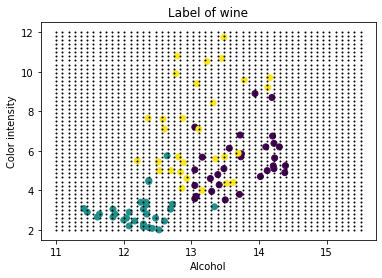

In [ ]:
plt.scatter(x=df["alcohol"], y=df["color_intensity"], c=df["labels"])
plt.xlabel("Alcohol")
plt.ylabel("Color intensity")
plt.title("Label of wine")

# Set the space on which the discrimination functions will be plotted
xlim = (11, 15.5)
ylim = (2, 12)
sample_rate = 50 

# Define the space
xg = np.linspace(xlim[0], xlim[1], sample_rate)
yg = np.linspace(ylim[0], ylim[1], sample_rate)

xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

#print(Xgrid.shape)
#print(Xgrid)

plt.plot(Xgrid[:,0], Xgrid[:,1], 'o', color='black', markersize=1)

Xgrid_df = pd.DataFrame(Xgrid, columns=["alcohol", "color_intensity"])

print(Xgrid_df.head)

#compute the posterior probability for each class for each sample
posterior = find_posterior(Xgrid_df, means, covs)

print(posterior)

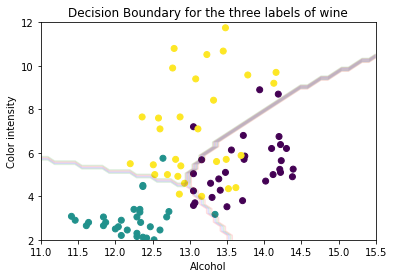

In [ ]:
#predict the class for each point in the grid 
predicted = np.argmax(posterior, axis=1)

#print("First 50 predicted classes: ", predicted[:50])

colors = ['red', 'green', 'blue']

plt.scatter(x=df["alcohol"], y=df["color_intensity"], c=df["labels"])
plt.contour(xx, yy, predicted.reshape(xx.shape), colors=colors, alpha=0.13)

plt.xlabel("Alcohol")
plt.ylabel("Color intensity")

plt.title("Decision Boundary for the three labels of wine")
plt.show()